In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv("TASK2_dataset.csv")

In [3]:
df = df.reset_index().rename(columns={"index": "Index"})
df.head()

,Index,song_id,keyword_1,keyword_2,keyword_3,genre
0,0,74,guitar,happy,distorted,rock
1,1,103,brass,energetic,melodic,classical
2,2,201,banjo,happy,acoustic,country
3,3,194,synth,energetic,heavy,hip-hop
4,4,184,synth,energetic,slow,hip-hop


In [ ]:
vocab=set()
l = []
for col in ['keyword_1', 'keyword_2', 'keyword_3']:
    vocab.update(df[col])
    
for i in range(147):
    ll = []
    word = df.loc[i]['keyword_1']
    ll.append(word)
    word = df.loc[i]['keyword_2']
    ll.append(word)
    word = df.loc[i]['keyword_3']
    ll.append(word)
    l.append(ll)
l
vocab = sorted(vocab)
vocab = list(vocab) #set of all the words that appeared in the keywords

In [ ]:
#Implementation of Bag Of Words Method
arr_bow1 = np.zeros((147,len(vocab)))
arr_bow2 = np.zeros((147,len(vocab)))
arr_bow3 = np.zeros((147,len(vocab)))
for i in range(147):
    word = df.loc[i]['keyword_1']
    arr_bow1[i][vocab.index(word)]=1
    word = df.loc[i]['keyword_2']
    arr_bow2[i][vocab.index(word)]=1
    word = df.loc[i]['keyword_3']
    arr_bow3[i][vocab.index(word)]=1


In [ ]:
#Implementation of TF-IDF method

#making the tf array
arr_tf1 = arr_bow1/3
arr_tf2 = arr_bow2/3
arr_tf3 = arr_bow3/3



In [ ]:
#making of idf array and tfidf array
freq = np.zeros(len(vocab))

for idx, word in enumerate(vocab):     
    for sublist in l:                   
        for w in sublist:
            if w == word:
                freq[idx] += 1

freq = np.array(freq)
arr_idf = np.log(147/freq)
arr_idf

arr_tfidf1 = np.zeros((147,23))
arr_tfidf2 = np.zeros((147,23))
arr_tfidf3 = np.zeros((147,23))

for i in range(147):
    for j in range(23):
        if arr_tf1[i][j]>0:
            arr_tfidf1[i][j] = arr_idf[j]/3
for i in range(147):
    for j in range(23):
        if arr_tf2[i][j]>0:
            arr_tfidf2[i][j] = arr_idf[j]/3
for i in range(147):
    for j in range(23):
        if arr_tf3[i][j]>0:
            arr_tfidf3[i][j] = arr_idf[j]/3
            

In [469]:
def pca(X, k = 2):
    
    X_centered = X - np.mean(X,axis = 0)
    cov_matrix = np.cov(X_centered, rowvar=False)
    
    eig_vals, eig_vecs = np.linalg.eig(cov_matrix)
    sorted_indices = np.argsort(eig_vals)[::-1]
    top_eig_vecs = eig_vecs[:, sorted_indices[:k]]

    X_reduced = X_centered @ top_eig_vecs

    
    
    return X_reduced

In [470]:
pca1 = pca(arr_bow1)
pca2 = pca(arr_bow2)
pca3 = pca(arr_bow3)

pcab = (pca1+ pca2+pca3)/3

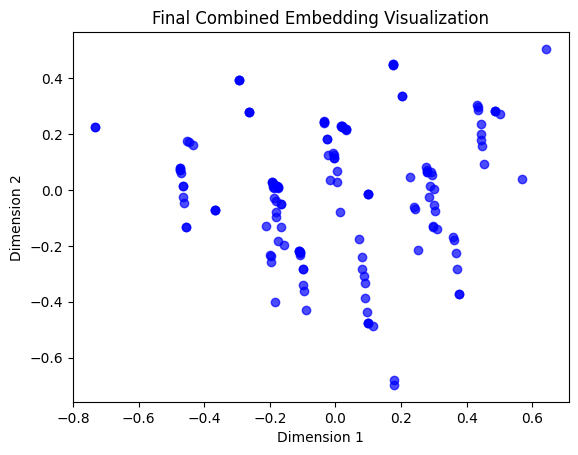

In [ ]:
#Plot of the array which was made by the PCA of the BOW array

plt.scatter(pcab[:, 0], pcab[:, 1],color='blue', alpha=0.7)
plt.title("Final Combined Embedding Visualization")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.show()


In [472]:
pca1 = pca(arr_tfidf1)
pca2 = pca(arr_tfidf2)
pca3 = pca(arr_tfidf3)

pcaa = (9*pca1+4*pca2+pca3)/14


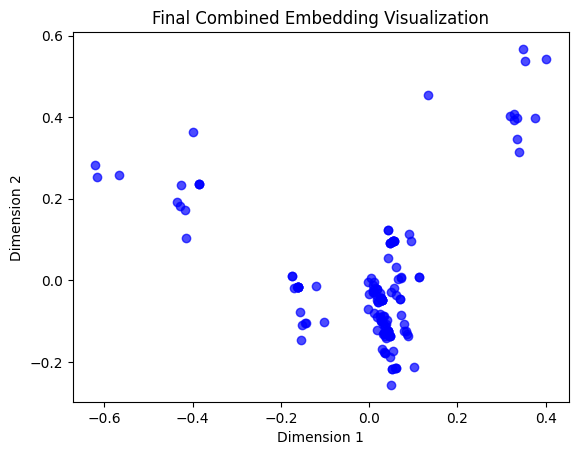

In [ ]:
#Plot of the array which was made by the PCA of the TF-ITF array

plt.scatter(pcaa[:, 0], pcaa[:, 1],color='blue', alpha=0.7)
plt.title("Final Combined Embedding Visualization")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.show()

#### In both graphs as you can see the graph made with tfitf has less clusters so it is a better choice and I will go further with it.

In [474]:
def kmeans(X,k):
    max_iter = 50
    x_coordinates = np.random.rand(k) * 2 - 1
    y_coordinates = np.random.rand(k) * 2 - 1
    points = np.column_stack((x_coordinates, y_coordinates))
    for o in range(max_iter):

        distances = np.linalg.norm(X[:, None, :] - points[None, :, :], axis=2)  # shape: (147, k)
        clusters = [[] for _ in range(k)]

        for i in range(147):
            clusters[np.argmin(distances[i])].append(i)
        new_points = np.zeros((k,2))
        for i in range(len(clusters)):
            count = 0
            for j in clusters[i]:
                new_points[i] += X[j]
                count = count + 1
            if count>0:
                new_points[i] = new_points[i]/count
        if np.allclose(points, new_points):
            break

        points = new_points
    return clusters, points


In [475]:
def variance(X,clusters,centroids):
    variance = 0.0
    for i, cluster in enumerate(clusters):
        for idx in cluster:
            variance += np.sum((X[idx] - centroids[i]) ** 2)
    return variance
        

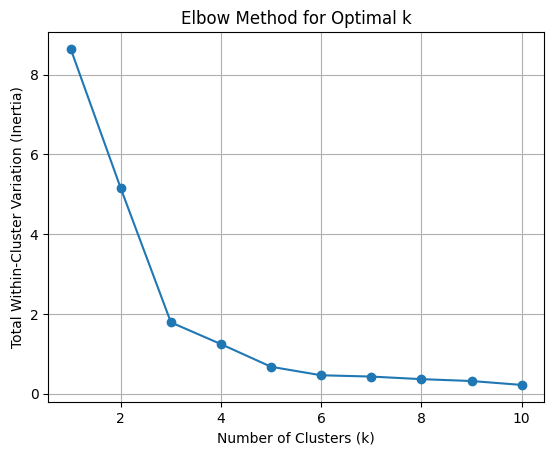

In [476]:
Ks = range(1,11)
variations = []

for k in Ks:
    clusters, centeroids = kmeans(pcaa,k)
    varian = variance(pcaa ,clusters, centeroids)
    variations.append(varian)
plt.plot(Ks, variations, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Total Within-Cluster Variation (Inertia)')
plt.title('Elbow Method for Optimal k')
plt.grid(True)
plt.show()

#### FROM THE EBLOW PLOT WE CAN SEE THAT K=3 is optimal

In [477]:
X = pcaa

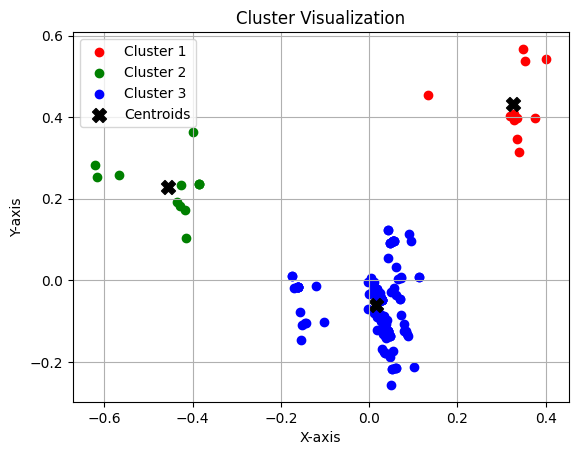

In [478]:
def plot_clusters(X, clusters, centroids):
    colors = ['r', 'g', 'b', 'c', 'm', 'y', 'k']  # Add more if k > 7

    for i, cluster in enumerate(clusters):
        cluster_points = X[cluster]
        plt.scatter(cluster_points[:, 0], cluster_points[:, 1], c=colors[i % len(colors)], label=f'Cluster {i+1}')

    plt.scatter(centroids[:, 0], centroids[:, 1], marker='X', c='black', s=100, label='Centroids')

    plt.title('Cluster Visualization')
    plt.xlabel('X-axis')
    plt.ylabel('Y-axis')
    plt.legend()
    plt.grid(True)
    plt.show()

clusters, centroids = kmeans(X, k=3)
plot_clusters(X, clusters, centroids)

In [479]:
from sklearn.metrics import silhouette_score
import numpy as np

def get_cluster_labels_array(clusters, n_samples):
    labels = np.empty(n_samples)
    for i, cluster in enumerate(clusters):
        for idx in cluster:
            labels[idx] = i
    return labels.astype(int)

cluster_labels = get_cluster_labels_array(clusters, len(X))
score = silhouette_score(X, cluster_labels)
print(f"Silhouette Score: {score:.3f}")

Silhouette Score: 0.742


In [480]:
genres = df["genre"].tolist()

df["genre"].nunique()

5

In [481]:
from collections import Counter

cluster_genre_dist = []

for cluster in clusters:
    genre_labels = [genres[i] for i in cluster]
    total = len(genre_labels)
    count = Counter(genre_labels)
    percentage = {g: (count[g] / total) * 100 for g in count}
    cluster_genre_dist.append(percentage)

for idx, dist in enumerate(cluster_genre_dist):
    print(f"Cluster {idx}:")
    for genre, pct in dist.items():
        print(f"  {genre}: {pct:.2f}%")



Cluster 0:
  classical: 100.00%
Cluster 1:
  pop: 50.00%
  classical: 50.00%
Cluster 2:
  rock: 24.19%
  country: 23.39%
  hip-hop: 24.19%
  classical: 8.06%
  pop: 20.16%
